In [ ]:
from IPython.core.debugger import set_trace

In [ ]:
import torch
from torch import nn, optim

import torchvision
import torchvision.transforms as transforms
import math
import matplotlib.pyplot as plt
import os

In [ ]:
torch.manual_seed(111)

In [ ]:
device = ''
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')


In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5,), (0.5,))])

In [ ]:
train_set = torchvision.datasets.MNIST(root='.',
                                      train=True,
                                      download=True,
                                      transform=transform)


In [ ]:
batch_size = 32
train_loader = torch.utils.data.DataLoader(train_set,
                                           batch_size=batch_size,
                                           shuffle=True)

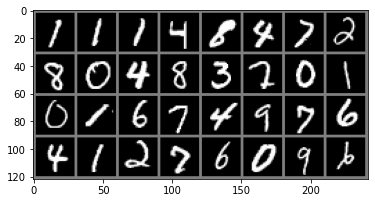

In [ ]:
import numpy as np

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

real_samples, mnist_labels = next(iter(train_loader))

imshow(torchvision.utils.make_grid(real_samples)) 

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, depth=1, alpha=0.2):
        super(Discriminator, self).__init__()
        # first set of CONV => RELU layers
        self.conv1 = nn.Conv2d(in_channels=depth, out_channels=32,
            kernel_size=4, stride=2, padding=1)
        self.leakyRelu1 = nn.LeakyReLU(alpha, inplace=True)
        # second set of CONV => RELU layers
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4,
            stride=2, padding=1)
        self.leakyRelu2 = nn.LeakyReLU(alpha, inplace=True)
        # first (and only) set of FC => RELU layers
        self.fc1 = nn.Linear(in_features=3136, out_features=512)
        self.leakyRelu3 = nn.LeakyReLU(alpha, inplace=True)
        # sigmoid layer outputting a single value
        self.fc2 = nn.Linear(in_features=512, out_features=1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # pass the input through first set of CONV => RELU layers
        x = self.conv1(x)
        x = self.leakyRelu1(x)
        # pass the output from the previous layer through our second
        # set of CONV => RELU layers
        x = self.conv2(x)
        x = self.leakyRelu2(x)
        # flatten the output from the previous layer and pass it
        # through our first (and only) set of FC => RELU layers
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = self.leakyRelu3(x)
        # pass the output from the previous layer through our sigmoid
        # layer outputting a single value
        x = self.fc2(x)
        output = self.sigmoid(x)
        # return the output
        return output

In [ ]:
class Generator(nn.Module):
    def __init__(self, inputDim=100, outputDim=512, outputChannels=1):
        super(Generator, self).__init__()
        # first set of CONVT => RELU => BN
        self.ct1 = nn.ConvTranspose2d(in_channels=inputDim,
          out_channels=128, kernel_size=4, stride=2, padding=0,
          bias=False)
        self.relu1 = nn.ReLU()
        self.batchNorm1 = nn.BatchNorm2d(128)
        # second set of CONVT => RELU => BN
        self.ct2 = nn.ConvTranspose2d(in_channels=128, out_channels=64,
              kernel_size=3, stride=2, padding=1, bias=False)
        self.relu2 = nn.ReLU()
        self.batchNorm2 = nn.BatchNorm2d(64)
        # last set of CONVT => RELU => BN
        self.ct3 = nn.ConvTranspose2d(in_channels=64, out_channels=32,
              kernel_size=4, stride=2, padding=1, bias=False)
        self.relu3 = nn.ReLU()
        self.batchNorm3 = nn.BatchNorm2d(32)
        # apply another upsample and transposed convolution, but
        # this time output the TANH activation
        self.ct4 = nn.ConvTranspose2d(in_channels=32,
          out_channels=outputChannels, kernel_size=4, stride=2,
          padding=1, bias=False)
        self.tanh = nn.Tanh()

    def forward(self, x):
        # pass the input through our first set of CONVT => RELU => BN
        # layers
        x = self.ct1(x)
        x = self.relu1(x)
        x = self.batchNorm1(x)
        # pass the output from previous layer through our second
        # CONVT => RELU => BN layer set
        x = self.ct2(x)
        x = self.relu2(x)
        x = self.batchNorm2(x)
        # pass the output from previous layer through our last set
        # of CONVT => RELU => BN layers
        x = self.ct3(x)
        x = self.relu3(x)
        x = self.batchNorm3(x)
        # pass the output from previous layer through CONVT2D => TANH
        # layers to get our output
        x = self.ct4(x)
        output = self.tanh(x)
        # return the output
        return output

In [ ]:
discriminator = Discriminator().to(device=device)

In [ ]:
generator = Generator().to(device=device)

In [ ]:
lr = 0.0001
num_epochs = 50
loss_function = nn.BCELoss()

optimizer_discriminator = torch.optim.Adam(discriminator.parameters(), lr=lr)
optimizer_generator = torch.optim.Adam(generator.parameters(), lr=lr)

In [ ]:
latent_space_samples_plot = torch.randn((16, 100)).to(device=device)

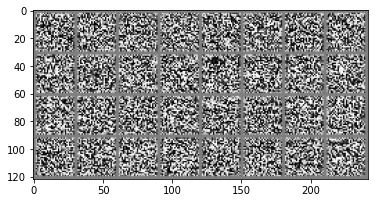

Epoch: 0 Loss D.: 0.6513934135437012
Epoch: 0 Loss G.: 0.7366020083427429


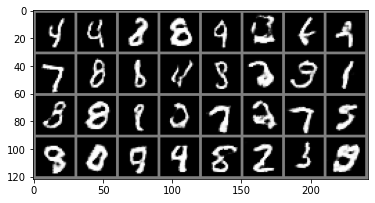

Epoch: 10 Loss D.: 0.4242227077484131
Epoch: 10 Loss G.: 1.1304473876953125


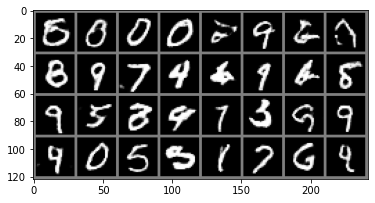

Epoch: 20 Loss D.: 0.39203470945358276
Epoch: 20 Loss G.: 1.7981550693511963


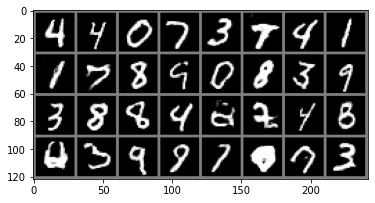

Epoch: 30 Loss D.: 0.40551984310150146
Epoch: 30 Loss G.: 1.5578057765960693


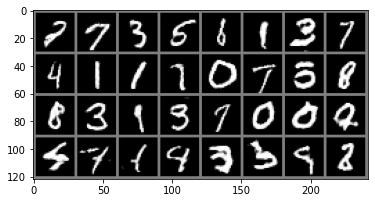

Epoch: 40 Loss D.: 0.3712482154369354
Epoch: 40 Loss G.: 1.6985647678375244


In [ ]:
discriminator_loss_plt = []
generator_loss_plt = []

for epoch in range(num_epochs):
    for n, (real_samples, mnist_labels) in enumerate(train_loader):
        # Data for training the discriminator
        real_samples = real_samples.to(device=device)
        real_samples_labels = torch.ones((batch_size, 1)).to(device=device)
        latent_space_samples = torch.randn((batch_size, 100, 1, 1)).to(device=device)
        generated_samples = generator(latent_space_samples)
        generated_samples_labels = torch.zeros(
            (batch_size, 1)).to(device=device)
        all_samples = torch.cat((real_samples, generated_samples))
        all_samples_labels = torch.cat(
            (real_samples_labels, generated_samples_labels))

        # Training the discriminator
        discriminator.zero_grad()
        output_discriminator = discriminator(all_samples)
        loss_discriminator = loss_function(
            output_discriminator, all_samples_labels)
        loss_discriminator.backward()
        optimizer_discriminator.step()

        discriminator_loss_plt.append(loss_discriminator.item())
    
        # Data for training the generator
        latent_space_samples = torch.randn((batch_size, 100, 1, 1)).to(device=device)

        # Training the generator            
        generator.zero_grad()
        generated_samples = generator(latent_space_samples)
        output_discriminator_generated = discriminator(generated_samples)
        loss_generator = loss_function(
            output_discriminator_generated, real_samples_labels)
        loss_generator.backward()
        optimizer_generator.step() 

        generator_loss_plt.append(loss_generator.item())

        if epoch % 10 == 0 and n == 0:
          imshow(torchvision.utils.make_grid(generated_samples.cpu().detach()))
          # Show loss
          print(f"Epoch: {epoch} Loss D.: {loss_discriminator}")
          print(f"Epoch: {epoch} Loss G.: {loss_generator}")

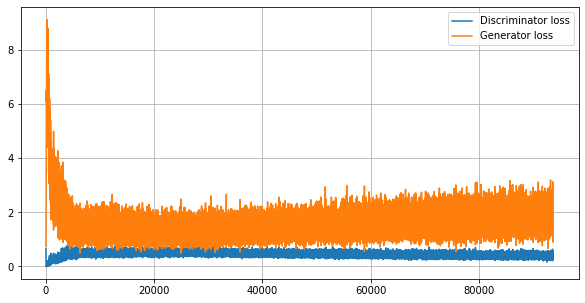

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(discriminator_loss_plt, label='Discriminator loss')
plt.plot(generator_loss_plt, label='Generator loss')
plt.legend()
plt.grid()
plt.show()